## Cost Analysis in Heallthcare Data
Healthcare cost analysis is a critical area of study that involves assessing and understanding the financial impact of healthcare services, procedures, and patient demographics. The goal is to identify cost drivers, trends, and potential areas for optimization while ensuring high-quality care delivery

### Spark Session Initialization:
A Spark session is initialized using SparkSession.builder. This session acts as the entry point for interacting with Apache Spark, enabling distributed data processing.


In [7]:
from numpy.lib.recfunctions import join_by
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import pandas as pd

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("ParquetFileReader") \
    .getOrCreate()



### Reading Parquet Files:
The code reads Parquet files located in the specified etl directory using Spark’s DataFrame API. Each file contains specific datasets related to healthcare:
	•	patient_df: Contains patient information, including demographic and personal details.
	•	claim_df: Holds healthcare claims data, likely detailing billing and payment records.
	•	encounter_df: Represents medical encounters, such as visits to healthcare providers or hospitalizations.
	•	procedures_df: Contains data about medical procedures performed during encounters, including diagnostics or treatments.
    
#### Purpose:
•	The goal is to load these datasets into Spark DataFrames for subsequent processing and analysis. By leveraging Spark’s distributed computing capabilities, the code can handle large datasets efficiently.


In [8]:
#File path to the Parquet file
file_path = "etl"

# Read the Parquet file into a Spark DataFrame
patient_df = spark.read.parquet(f"{file_path}/patient")
encounter_df = spark.read.parquet(f"{file_path}/encounter")
claim_df = spark.read.parquet(f"{file_path}/claim")
procedures_df = spark.read.parquet(f"{file_path}/procedure")



### Data Selection and Transformation:
The provided Spark code is designed to process and integrate healthcare datasets from multiple sources (patients,claims, encounters, and procedures). It performs data selection, transformation, and joining operations to create unified views of the data for analysis.

#### Purpose and Utility:
	
##### Data Preparation:
•	The code prepares clean, standardized datasets by selecting relevant columns and performing necessary transformations.
•	Joins ensure relationships between patients, claims, encounters, and procedures are established.



In [9]:
def select_patients_data(patient_df):
    return patient_df.select(
        'patient_id', 'first_name', 'last_name','gender', 'birth_date'
        )

In [10]:
def select_claim_data(claim_df):
    return claim_df.select(
        claim_df['patient_reference'].alias('patient_id'),
        'claim_id', 'total_amount','currency','insurance_coverage_display'
        )

In [11]:
def select_procedures_data(procedures_df):
    return procedures_df.select(
        'procedure_id',
        F.split(procedures_df['encounter_reference'], 'urn:uuid:').getItem(1).alias('encounter_id'),
        'procedure_code_display'
    )

In [12]:
def select_encounter_data(encounter_df):
    return encounter_df.select(
        'encounter_id',
        encounter_df['patient_reference'].alias('patient_id'),
        'start_time',
        'end_time',
        'service_provider_id',
        'service_provider_display',
        'type_text'
        )

In [13]:
patients = select_patients_data(patient_df)
encounters = select_encounter_data(encounter_df)
claims = select_claim_data(claim_df)
procedure = select_procedures_data(procedures_df)

In [14]:

claims_encounters_df = claims.join(encounters, "patient_id", "left")
procedure_claim_df = procedure.join(claims_encounters_df, "encounter_id", "left")
#procedure_claim_df.show()
    

## Cost analysis based on Encounters
Cost analysis based on healthcare encounters evaluates the expenses associated with individual episodes of care, such as doctor visits, hospital admissions, emergency room visits, or outpatient procedures. This type of analysis provides granular insights into the cost dynamics of patient interactions with the healthcare system and supports better decision-making at both clinical and administrative levels and to plance the healthcare resources accordingly.
### Top 10 High Encounters:

#### Code Description:
below section of the code identifies and visualizes the top 10 highest-cost encounters from the healthcare claims data. 
 
#### Insights:
•	The bar plot provides a clear visual representation of the distribution of claim amounts across different types of encounters. It highlights which encounter types contribute the most to high healthcare costs.

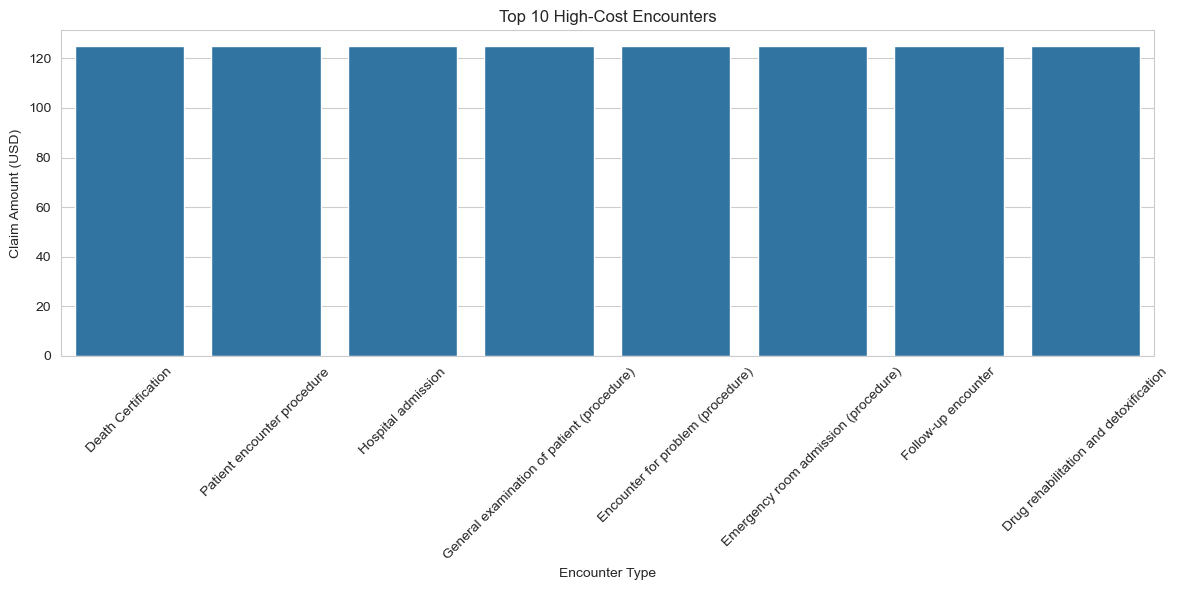

In [15]:
# Select the top 10 high-cost encounters
high_cost_encounters = claims_encounters_df.orderBy(F.desc('total_amount')).limit(10)
#high_cost_encounters.show()
# Convert to Pandas for plotting
high_cost_encounters_pd = high_cost_encounters.toPandas()

# Plot the top 10 high-cost encounters
plt.figure(figsize=(12, 6))
sns.barplot(data=high_cost_encounters_pd, x="type_text", y="total_amount")
plt.title("Top 10 High-Cost Encounters")
plt.xlabel("Encounter Type")
plt.ylabel("Claim Amount (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Total Cost per Encounters 

##### Code Description:
below section of the code calculates and visualizes the total cost, average cost, and number of encounters for each healthcare encounter type from the claims data

##### Insights:
•	The bar plot provides a clear visual representation of the total costs associated with different types of encounters.
	•	It highlights which encounter types contribute the most to overall healthcare costs, enabling stakeholders to identify cost-intensive areas.
	•	The analysis allows for deeper exploration into high-cost encounter types to develop targeted strategies for cost optimization.


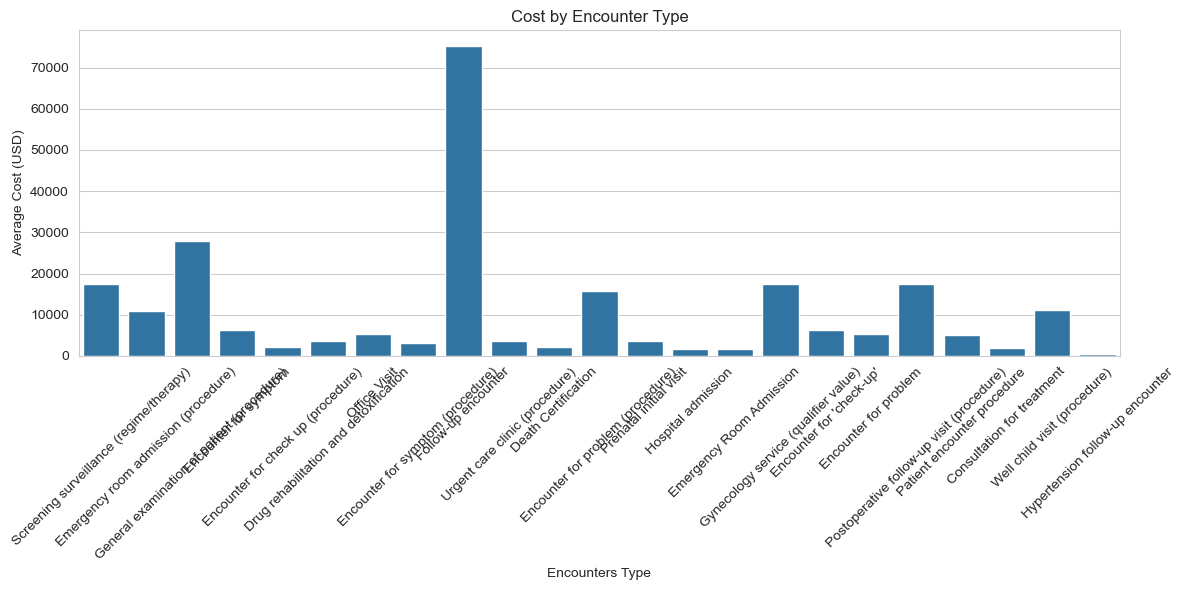

In [13]:
encounter_cost_analysis = claims_encounters_df.groupBy("type_text").agg(
    F.mean("total_amount").alias("avg_cost"),
    F.sum("total_amount").alias("total_cost"),
    F.count("total_amount").alias("num_encounters")
)

# Convert to Pandas DataFrame for plotting
encounter_cost_analysis_pd = encounter_cost_analysis.toPandas()

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=encounter_cost_analysis_pd, x="type_text", y="total_cost")
plt.title("Cost by Encounter Type")
plt.xlabel("Encounters Type")
plt.ylabel("Average Cost (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cost analysis based on service providers
Cost analysis based on service providers examines how healthcare expenses vary across different healthcare facilities, providers, and care delivery models. This type of analysis is essential for identifying inefficiencies, understanding cost drivers, and improving both the affordability and quality of care

#### Code Description:

This section of the code calculates and visualizes the total cost, average cost, and number of encounters associated with each healthcare service provider.

#### Insights:
•	The bar plot provides a clear view of the distribution of total healthcare costs across service providers.
	•	Service providers with the highest total costs are easily identifiable, offering insights into which providers handle the most expensive encounters.
	•	This analysis is critical for evaluating provider performance and identifying cost optimization opportunities within the healthcare system.

+------------------------+----------+--------+--------------+
|service_provider_display|total_cost|avg_cost|num_encounters|
+------------------------+----------+--------+--------------+
|     Clinique Providence|   24500.0|   125.0|           196|
|    Centre Hospitalie...|  187250.0|   125.0|          1498|
|    North York Genera...|   13000.0|   125.0|           104|
|    North York Family...|   10000.0|   125.0|            80|
|    Dr. y.k. Jeon Kit...|    1500.0|   125.0|            12|
|    Rencontre East Co...|    3500.0|   125.0|            28|
|    Powell River Gene...|    2250.0|   125.0|            18|
|    Washington Park M...|    3375.0|   125.0|            27|
+------------------------+----------+--------+--------------+



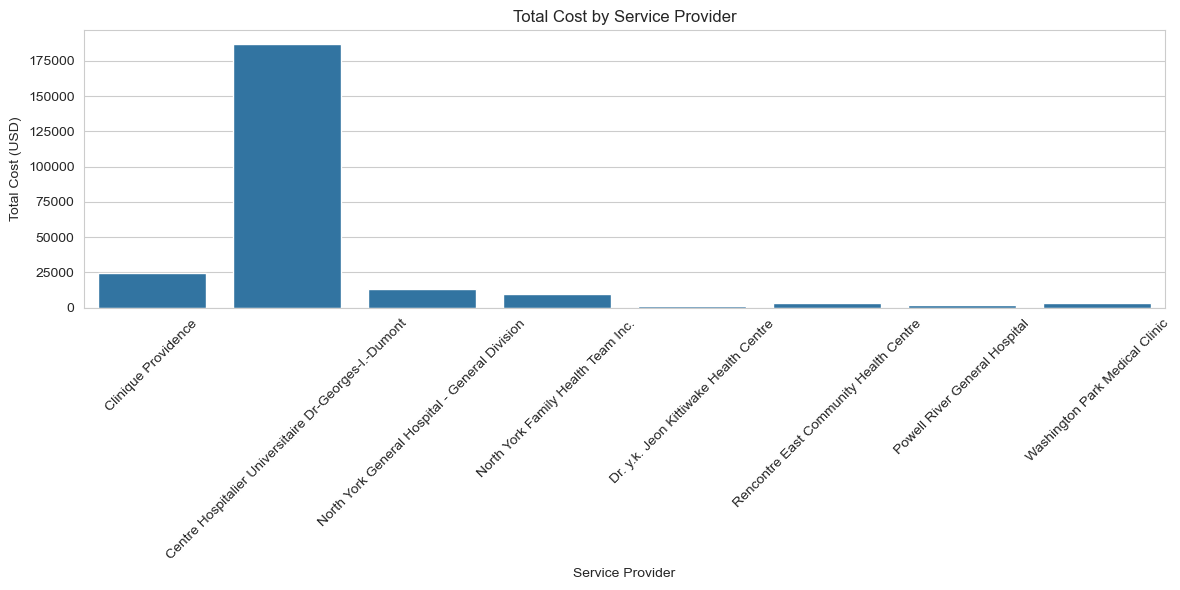

In [15]:
# 3. Total cost by service provider
from pyspark.sql.functions import when, col

# Replace null or empty service_provider_display with "Others"
claims_encounters_df = claims_encounters_df.withColumn(
    "service_provider_display",
    when(
        (col("service_provider_display").isNull()) | (col("service_provider_display") == ""),
        "Others"
    ).otherwise(col("service_provider_display"))
)

# Group by and aggregate
provider_analysis = claims_encounters_df.groupby("service_provider_display").agg(
    F.sum("total_amount").alias("total_cost"),
    F.mean("total_amount").alias("avg_cost"),
    F.count("total_amount").alias("num_encounters")
)
provider_analysis.show()
# Convert to Pandas DataFrame for plotting
provider_analysis_pd = provider_analysis.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=provider_analysis_pd, x="service_provider_display", y="total_cost")
plt.title("Total Cost by Service Provider")
plt.xlabel("Service Provider")
plt.ylabel("Total Cost (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Gender based cost analysis
Gender-based cost analysis in healthcare investigates the differences in healthcare spending and utilization patterns between male, female, and other gender categories. This type of analysis is vital for understanding disparities in healthcare access, needs, and outcomes across genders, enabling more equitable and effective healthcare delivery

#### Code Description:

This section of the code analyzes healthcare costs based on gender by cleaning data, joining datasets, aggregating costs, and visualizing the results.

#### Insights:
•	The pie chart provides a straightforward visualization of the distribution of total healthcare costs by gender.
	•	It highlights gender-based cost trends, revealing which gender accounts for a larger share of healthcare expenditures.
	•	Such analysis can guide resource allocation and targeted healthcare policies to address disparities in costs across genders.



Total Costs by Gender
   gender  total_cost
0  female      3250.0
1    male       375.0


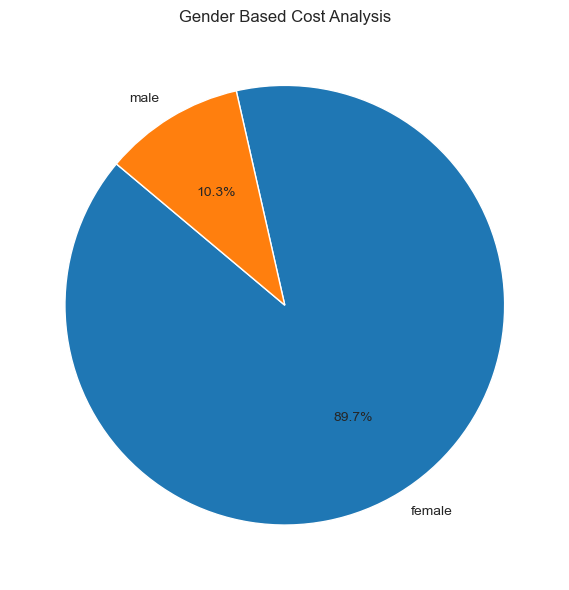

In [18]:
# Extract the part of `patient_id` after 'urn:uuid:'
claims = claims.withColumn(
    "patient_id_clean", F.split(claims["patient_id"], "urn:uuid:").getItem(1)
)

# Join claims with patients on the cleaned patient_id
gender_distribution = claims.join(
    patients, claims["patient_id_clean"] == patients["patient_id"], "left"
)

# Compute total and average cost by gender
cost_stats = (
    gender_distribution.groupBy("gender")
    .agg(
        F.sum("total_amount").alias("total_cost")  # Total cost per gender       
    )
    .orderBy(F.desc("total_cost"))  # Order by total cost for better insight
    .toPandas()
)

# Display the results
print("Total Costs by Gender")
print(cost_stats)

# Plot pie chart for total costs by gender
plt.figure(figsize=(6, 6))
plt.pie(
    cost_stats['total_cost'],
    labels=cost_stats['gender'],
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Gender Based Cost Analysis")
plt.tight_layout()
plt.show()


### Age based cost analysis
Age-based cost analysis is a critical approach in healthcare that examines the distribution of healthcare costs across different age groups. This analysis provides insights into how healthcare expenses vary with age and helps stakeholders understand, predict, and manage healthcare needs and budgets effectively.

#### Code Description:

This section of the code analyzes healthcare costs by age group by deriving age from birthdate, categorizing patients into age ranges, and calculating total costs for each group.

#### Insights:
•	The bar chart visually represents the distribution of healthcare costs across different age groups.
	•	It identifies which age ranges account for the highest healthcare expenditures, providing valuable insights into age-related cost trends.
	•	Such analysis can inform resource allocation, age-specific healthcare programs, and policies to optimize costs for high-expenditure age groups.

Age-Based Cost Analysis
  age_range  total_cost
0      0-18      1000.0
1     19-35       375.0
2     51-65       500.0
3       66+      1750.0


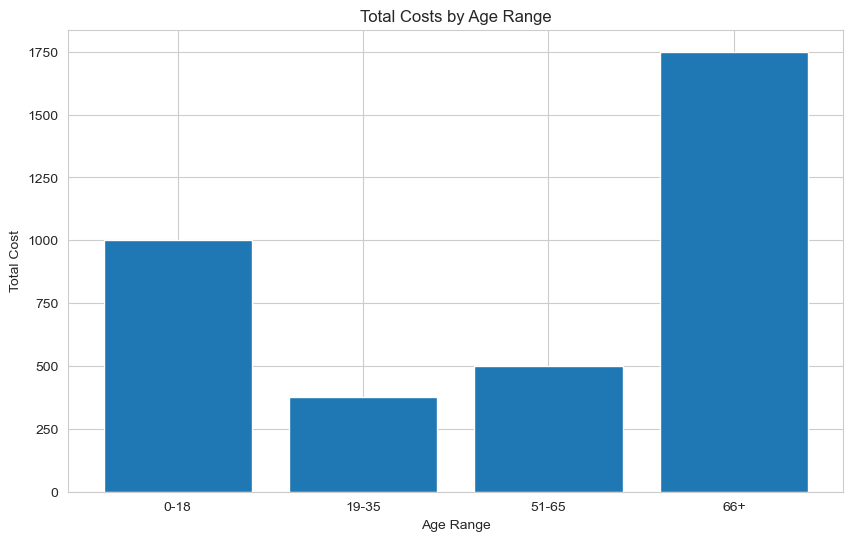

In [58]:
# Add an 'age' column based on the birthdate
from pyspark.sql.functions import year, current_date, when, col
gender_distribution = gender_distribution.withColumn(
    "age", year(current_date()) - year(gender_distribution["birth_date"])
)

# Define age ranges
gender_distribution = gender_distribution.withColumn(
    "age_range",
    when(col("age") <= 18, "0-18")
    .when((col("age") > 18) & (col("age") <= 35), "19-35")
    .when((col("age") > 35) & (col("age") <= 50), "36-50")
    .when((col("age") > 50) & (col("age") <= 65), "51-65")
    .otherwise("66+")
)

# Compute total and average cost by age range
age_cost_stats = (
    gender_distribution.groupBy("age_range")
    .agg(
        F.sum("total_amount").alias("total_cost"),  # Total cost per age range
    )
    .orderBy("age_range")  # Order by age range for logical flow
    .toPandas()
)

# Display the results
print("Age-Based Cost Analysis")
print(age_cost_stats)


# Bar chart for total costs by age range
plt.figure(figsize=(10, 6))
plt.bar(age_cost_stats['age_range'], age_cost_stats['total_cost'])
plt.title("Total Costs by Age Range")
plt.xlabel("Age Range")
plt.ylabel("Total Cost")
plt.show()


### Cost Analysis by Procedures
Cost analysis by procedures evaluates the costs associated with specific medical procedures or treatments. This helps stakeholders understand which procedures contribute most to overall healthcare expenditures, optimize pricing, and improve resource allocation. Particularly focusing on the top 10 procedures, is a strategic approach to understanding and managing healthcare expenses. It helps identify cost drivers, optimize resource allocation, and improve decision-making while enabling targeted strategies for cost reduction and enhanced patient care.

#### Code Description:

This section of the code performs an analysis of healthcare procedures, focusing on their costs and frequencies, and generates visualizations to highlight the most significant trends.

#### Insights:
•	The Total Cost by Procedure chart identifies procedures that contribute the most to overall healthcare expenditures.
	•	The Frequency of Procedures plot highlights the most commonly performed procedures, offering insights into procedural trends and demand.
	•	The Average Cost by Procedure visualization reveals which procedures are the most expensive on a per-instance basis, allowing for targeted cost-reduction efforts.
	•	This analysis is essential for healthcare administrators and insurers to prioritize resource allocation and optimize procedure-related costs.
	


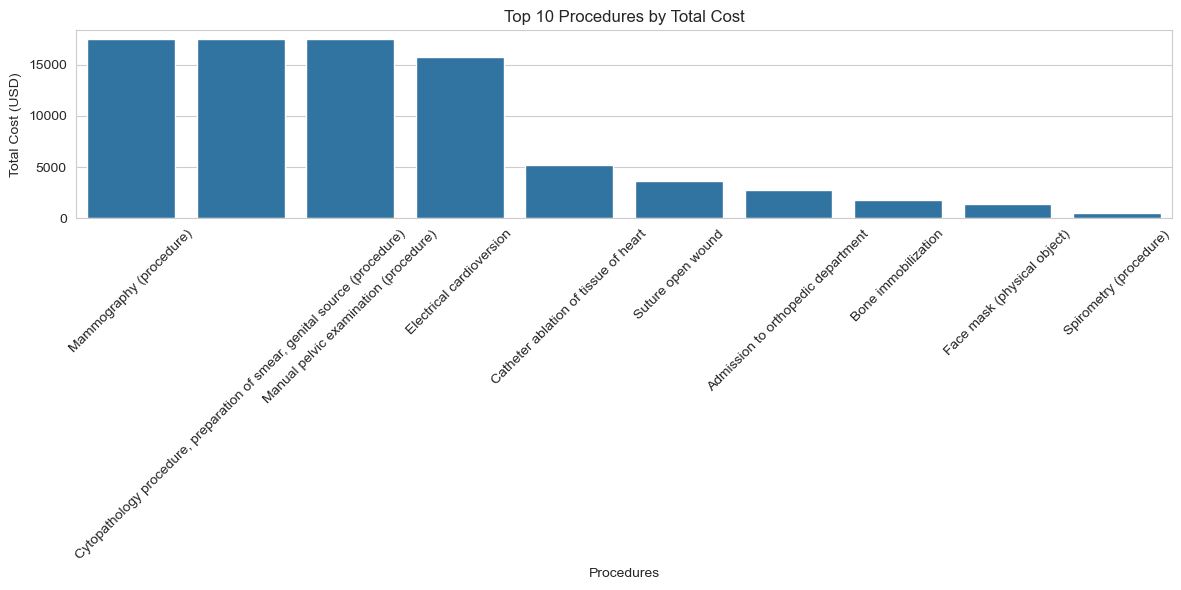

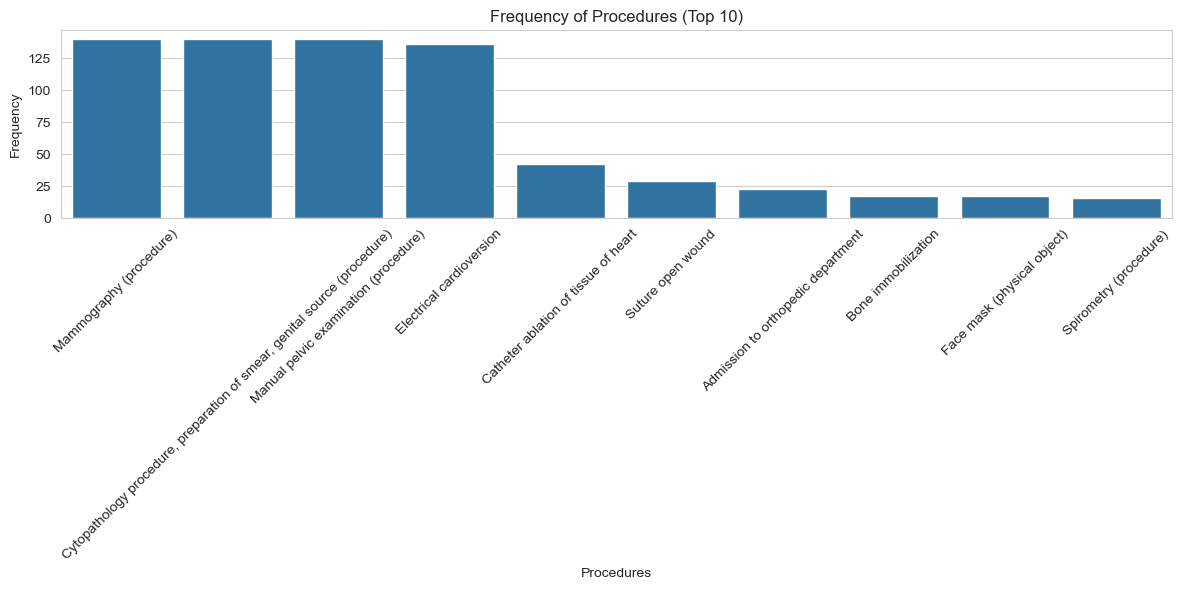

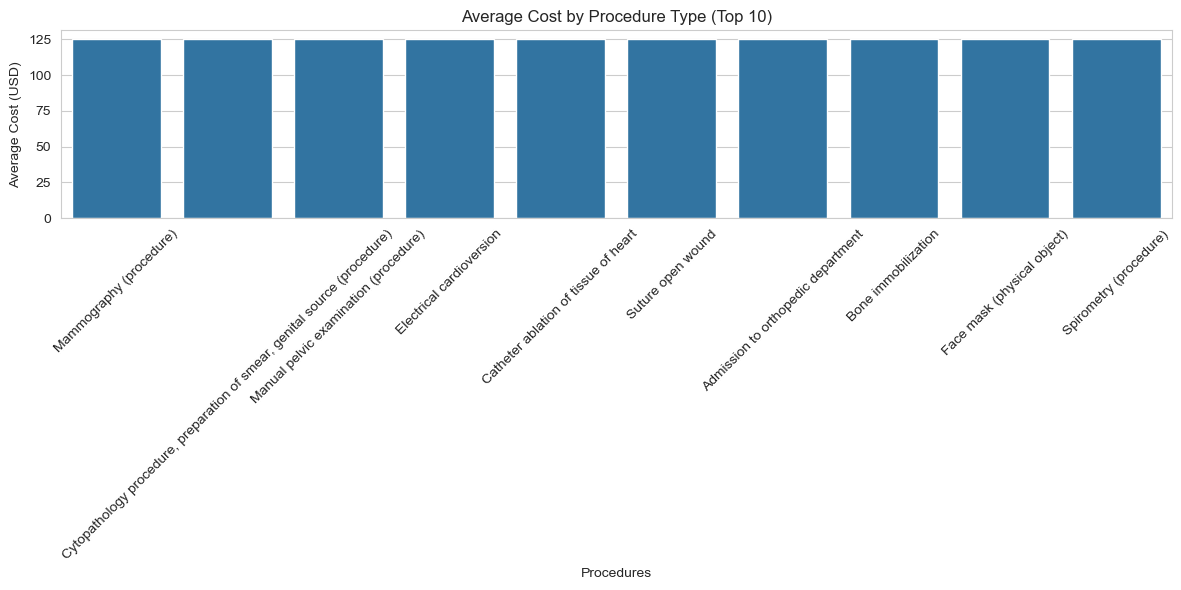

In [27]:
procedure_cost_analysis = procedure_claim_df.groupBy("procedure_code_display").agg(
    F.sum('total_amount').alias("total_cost"),
    F.avg("total_amount").alias("avg_cost"),
    F.count("procedure_code_display").alias("frequency")
)

# Convert to Pandas for visualisation
procedure_cost_analysis_pd = (
    procedure_cost_analysis.orderBy(F.desc("total_cost")).limit(10).toPandas()
)

# Visualization: Total cost by procedure
plt.figure(figsize=(12, 6))
sns.barplot(data=procedure_cost_analysis_pd, x="procedure_code_display", y="total_cost")
plt.title("Top 10 Procedures by Total Cost")
plt.xlabel("Procedures")
plt.ylabel("Total Cost (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization: Frequency of procedures
plt.figure(figsize=(12, 6))
sns.barplot(data=procedure_cost_analysis_pd, x="procedure_code_display", y="frequency")
plt.title("Frequency of Procedures (Top 10)")
plt.xlabel("Procedures")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization: Average cost by procedure
plt.figure(figsize=(12, 6))
sns.barplot(data=procedure_cost_analysis_pd, x="procedure_code_display", y="avg_cost")
plt.title("Average Cost by Procedure Type (Top 10)")
plt.xlabel("Procedures")
plt.ylabel("Average Cost (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()